# MNIST High-Accuracy MLP (99.4%+)

**Objective:** Achieve state-of-the-art accuracy on the MNIST dataset using a robust Multi-Layer Perceptron (MLP) architecture.

**Author:** Sergi Cortés Guerrero

**Key Features:**
- **Data Augmentation:** Random rotation and affine transformations to improve generalization.
- **Robust Architecture:** Deep MLP with Batch Normalization and Dropout.
- **Optimization:** AdamW optimizer with OneCycleLR scheduler.
- **Early Stopping:** Prevents overfitting by monitoring validation accuracy.
- **Reproducibility:** Fixed random seeds for consistent results.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
import os

## 1. Configuration & Setup

In [4]:
def set_seed(seed=42):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(22)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Hyperparameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
MAX_EPOCHS = 100
PATIENCE = 20

Using device: mps


## 2. Data Pipeline

In [5]:
def get_dataloaders():
    """Prepares MNIST DataLoaders with Augmentation."""
    # Augmentation for Training
    train_transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Standard Transform for Val/Test
    val_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    # Load Datasets
    full_train = datasets.MNIST('./data', train=True, download=True, transform=train_transform)
    full_train_clean = datasets.MNIST('./data', train=True, download=True, transform=val_test_transform)
    test_set = datasets.MNIST('./data', train=False, download=True, transform=val_test_transform)

    # Split 60k Train -> 54k Train / 6k Val
    total_size = len(full_train)
    train_size = int(0.9 * total_size)
    indices = list(range(total_size))
    np.random.shuffle(indices)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_set = Subset(full_train, train_indices)
    val_set = Subset(full_train_clean, val_indices)

    # Loaders
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1000)
    test_loader = DataLoader(test_set, batch_size=1000)
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_dataloaders()

## 3. Model Architecture (MLP)

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.fc4 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.dropout(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.relu(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x

## 4. Training Engine

In [7]:
def train_epoch(model, loader, optimizer, scheduler):
    model.train()
    total_loss, correct = 0, 0
    for data, target in loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item() * data.size(0)
        correct += output.argmax(1).eq(target).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def validate(model, loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            total_loss += F.cross_entropy(output, target, reduction='sum').item()
            correct += output.argmax(1).eq(target).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(train_losses, label='Train')
    ax1.plot(val_losses, label='Val')
    ax1.set_title('Loss'); ax1.legend()
    ax2.plot(train_accs, label='Train')
    ax2.plot(val_accs, label='Val')
    ax2.set_title('Accuracy'); ax2.legend()
    plt.show()

In [8]:
def run_training():
    model = MLP().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_loader), epochs=MAX_EPOCHS)
    
    best_acc = 0.0
    patience_counter = 0
    metrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    print("Starting Training...")
    for epoch in range(1, MAX_EPOCHS + 1):
        start = time.time()
        t_loss, t_acc = train_epoch(model, train_loader, optimizer, scheduler)
        v_loss, v_acc = validate(model, val_loader)
        
        metrics['train_loss'].append(t_loss); metrics['val_loss'].append(v_loss)
        metrics['train_acc'].append(t_acc); metrics['val_acc'].append(v_acc)
        
        plot_metrics(metrics['train_loss'], metrics['val_loss'], metrics['train_acc'], metrics['val_acc'])
        print(f"Epoch {epoch}/{MAX_EPOCHS} | Train Loss: {t_loss:.4f} Acc: {t_acc:.4f} | Val Loss: {v_loss:.4f} Acc: {v_acc:.4f} | Time: {time.time()-start:.1f}s")

        if v_acc > best_acc:
            best_acc = v_acc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print("Early Stopping Triggered.")
                break
    
    return model

## 5. Execution & Evaluation

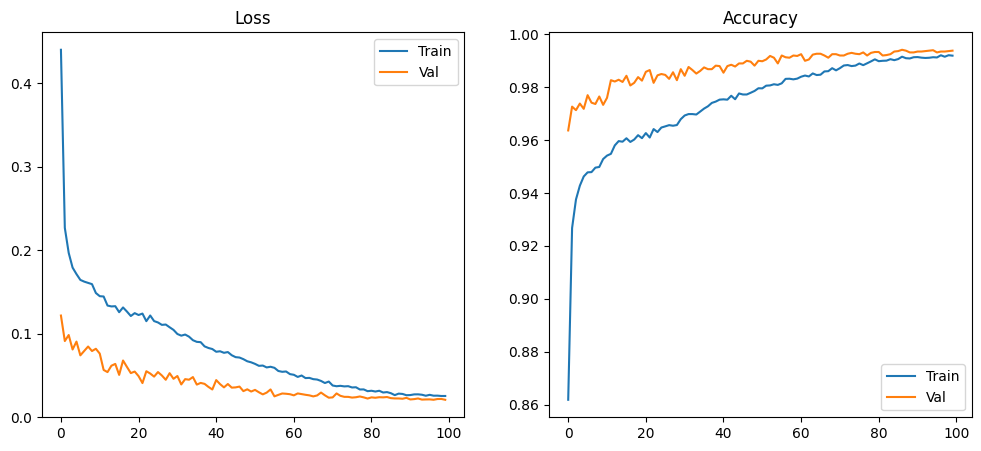

Epoch 100/100 | Train Loss: 0.0255 Acc: 0.9919 | Val Loss: 0.0209 Acc: 0.9938 | Time: 10.5s

Loading Best Model for Evaluation...

>>> Final Test Accuracy: 0.9943 <<<

Classification Report:
              precision    recall  f1-score   support

           0     0.9969    0.9969    0.9969       980
           1     0.9965    0.9965    0.9965      1135
           2     0.9952    0.9942    0.9947      1032
           3     0.9941    0.9950    0.9946      1010
           4     0.9949    0.9908    0.9929       982
           5     0.9911    0.9955    0.9933       892
           6     0.9948    0.9948    0.9948       958
           7     0.9874    0.9942    0.9908      1028
           8     0.9990    0.9938    0.9964       974
           9     0.9930    0.9911    0.9921      1009

    accuracy                         0.9943     10000
   macro avg     0.9943    0.9943    0.9943     10000
weighted avg     0.9943    0.9943    0.9943     10000



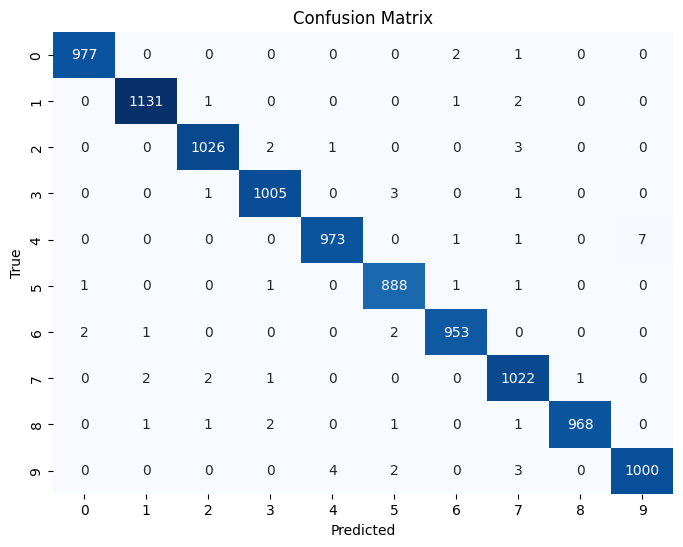

In [9]:
# 1. Train
run_training()

# 2. Load Best Model
print("\nLoading Best Model for Evaluation...")
model = MLP().to(DEVICE)
model.load_state_dict(torch.load('best_model.pth'))

# 3. Evaluate on Test Set
loss, acc = validate(model, test_loader)
print(f"\n>>> Final Test Accuracy: {acc:.4f} <<<")

# 4. Detailed Metrics
all_preds, all_targets = [], []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(DEVICE), target.to(DEVICE)
        all_preds.extend(model(data).argmax(1).cpu().numpy())
        all_targets.extend(target.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_targets, all_preds, digits=4))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(all_targets, all_preds), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix'); plt.ylabel('True'); plt.xlabel('Predicted')
plt.show()